In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import optuna


In [ ]:
# Ejemplo: definir manualmente tipos de columnas

dtype_mapping = {
    # IDs - verificados contra los valores máximos
    'product_id': 'uint16',   # Máx 21299 < 65535
    'customer_id': 'uint16',  # Máx 10637 < 65535
    
    # Fechas en formato YYYYMM
    'periodo': 'uint32',
    'nacimiento_producto': 'uint32',
    'muerte_cliente': 'uint32',
    
    # Variables float - convertidas a 32 bits
    'periodo_producto': 'float32',
    'tn': 'float32',
    'cust_request_tn': 'float32',
    'lag_1m': 'float32',
    'lag_2m': 'float32',
    'lag_3m': 'float32',
    'lag_11m': 'float32',
    'rolling_3m_mean': 'float32',
    'rolling_6m_mean': 'float32',
    'rolling_12m_mean': 'float32',
    'annual_trend': 'float32',
    'seasonal_variation': 'float32',
    'size_vs_category': 'float32',

    
    # Variables enteras - ajustadas al rango
    'cust_request_qty': 'float32',   # Máx 142 < 255
    'sku_size': 'float32',         # Máx 10000 < 65535
    
    # Variables categóricas
    'cat1': 'category',
    'cat2': 'category',
    'cat3': 'category',
    
    # variables 2da tanda
    # 'tn_por_unidad': 'float32',
    # 'ratio_entregado_sobre_pedido': 'float32',
    # 'proporcion_producto_en_total_mes': 'float32',
    # 'total_cliente_mes': 'float32',
    # 'productos_distintos_cliente_mes':'int16',
    # 'meses_hasta_muerte_cliente': 'int16',
    # 'meses_desde_nacimiento_producto': 'int16',
    # 'participacion_producto': 'float32',
    # 'trend_3m': 'float32',
    # 'modo_6m': 'float32',
    # 'freq_compra_12m': 'float32',
    # 'freq_compra_6m': 'float32',
    # 'freq_compra_3m': 'float32',
    # 'periodos_desde_ultima_compra': 'int16',
    # 'comprado': 'int8',
    
    
}

df = pd.read_csv('../datasets/dt_fe.csv', sep=',')

KeyboardInterrupt: 

In [26]:
df.dtypes

product_id                           uint16
customer_id                          uint16
periodo                              uint32
periodo_producto                    float16
nacimiento_producto                  uint32
muerte_cliente                       uint32
tn                                  float16
cust_request_tn                     float32
cust_request_qty                    float32
cat1                                  int32
cat2                                  int32
cat3                                  int32
brand                                 int32
sku_size                            float32
stock_final                         float32
plan_precios_cuidados                 int32
target                              float32
month                                 uint8
year                                 uint16
quarter                               uint8
semester                              uint8
is_month_end                           bool
season                          

In [17]:
def optimize_memory_usage(df, verbose=True, convert_bool=True):
    """
    Optimiza el uso de memoria de un DataFrame reduciendo tipos numéricos, booleanos, categóricos y fechas.
    
    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame original a optimizar.
    verbose : bool, opcional (default=True)
        Si True, muestra información sobre la reducción de memoria.
    convert_bool : bool, opcional (default=True)
        Si True, convierte columnas binarias a booleanas.
    
    Retorna:
    --------
    pd.DataFrame
        DataFrame optimizado con tipos de datos reducidos.
    """
    import pandas as pd
    import numpy as np

    df_optimized = df.copy()
    start_mem = df_optimized.memory_usage(deep=True).sum() / 1024**2

    for col in df_optimized.columns:
        col_type = df_optimized[col].dtypes

        if pd.api.types.is_numeric_dtype(col_type):
            col_min = df_optimized[col].min()
            col_max = df_optimized[col].max()

            if pd.api.types.is_integer_dtype(col_type):
                if col_min >= 0:
                    if col_max <= np.iinfo(np.uint8).max:
                        df_optimized[col] = df_optimized[col].astype(np.uint8)
                    elif col_max <= np.iinfo(np.uint16).max:
                        df_optimized[col] = df_optimized[col].astype(np.uint16)
                    elif col_max <= np.iinfo(np.uint32).max:
                        df_optimized[col] = df_optimized[col].astype(np.uint32)
                    else:
                        df_optimized[col] = df_optimized[col].astype(np.uint64)
                else:
                    if col_min >= np.iinfo(np.int8).min and col_max <= np.iinfo(np.int8).max:
                        df_optimized[col] = df_optimized[col].astype(np.int8)
                    elif col_min >= np.iinfo(np.int16).min and col_max <= np.iinfo(np.int16).max:
                        df_optimized[col] = df_optimized[col].astype(np.int16)
                    elif col_min >= np.iinfo(np.int32).min and col_max <= np.iinfo(np.int32).max:
                        df_optimized[col] = df_optimized[col].astype(np.int32)
                    else:
                        df_optimized[col] = df_optimized[col].astype(np.int64)

            elif pd.api.types.is_float_dtype(col_type):
                if not df_optimized[col].isnull().any():
                    if col_min >= np.finfo(np.float16).min and col_max <= np.finfo(np.float16).max:
                        df_optimized[col] = df_optimized[col].astype(np.float16)
                    elif col_min >= np.finfo(np.float32).min and col_max <= np.finfo(np.float32).max:
                        df_optimized[col] = df_optimized[col].astype(np.float32)
                    else:
                        df_optimized[col] = df_optimized[col].astype(np.float64)
                else:
                    # Con NaNs, evitamos float16
                    if col_min >= np.finfo(np.float32).min and col_max <= np.finfo(np.float32).max:
                        df_optimized[col] = df_optimized[col].astype(np.float32)

        elif pd.api.types.is_object_dtype(col_type):
            num_unique = df_optimized[col].nunique()
            num_total = len(df_optimized[col])
            if num_unique / num_total < 0.5:
                df_optimized[col] = df_optimized[col].astype('category')

        elif pd.api.types.is_bool_dtype(col_type):
            df_optimized[col] = df_optimized[col].astype('bool')

        elif convert_bool and df_optimized[col].dropna().nunique() == 2:
            # Convertir columnas binarias a booleanas si no lo son aún
            unique_vals = df_optimized[col].dropna().unique()
            if set(unique_vals) <= {0, 1} or set(unique_vals) <= {True, False}:
                df_optimized[col] = df_optimized[col].astype('bool')

        elif pd.api.types.is_datetime64_any_dtype(col_type):
            # Ya está optimizada
            continue

        elif col_type == 'object':
            try:
                parsed_dates = pd.to_datetime(df_optimized[col], errors='coerce')
                if parsed_dates.notna().sum() > 0.9 * len(df_optimized[col]):
                    df_optimized[col] = parsed_dates
            except Exception:
                pass

    end_mem = df_optimized.memory_usage(deep=True).sum() / 1024**2

    if verbose:
        print(f"Memoria inicial: {start_mem:.2f} MB")
        print(f"Memoria final:   {end_mem:.2f} MB")
        print(f"Reducción:       {100 * (start_mem - end_mem) / start_mem:.2f}%")

    return df_optimized
# Optimizar el uso de memoria del DataFrame
df = optimize_memory_usage(df)

Memoria inicial: 6598.18 MB
Memoria final:   2382.99 MB
Reducción:       63.88%


In [18]:
# Codificar categóricas
cat_cols = ['cat1', 'cat2', 'cat3', 'brand', 'plan_precios_cuidados']
for col in cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        

df = df.drop(['periodo_dt'], axis=1, errors='ignore')
df_kgl = df[df["periodo"] == 201912]
df = df[~df["periodo"].isin([201911, 201912])]
# Separar features y target
X = df.drop(columns=["target"])
y = df["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [19]:


# Ruta a la base de datos
DB_PATH = "optuna_storage/optuna_simple.db"

# Cargar el estudio almacenado
study = optuna.load_study(
    study_name=None,  # Usar None si solo hay un estudio en la DB, o especificar el nombre
    storage=f"sqlite:///{DB_PATH}"
)

# Obtener los mejores hiperparámetros
best_params = study.best_params
best_value = study.best_value

print("Mejores hiperparámetros encontrados:")
print(best_params)
print(f"Mejor valor objetivo: {best_value}")

[I 2025-06-01 13:47:47,648] Study name was omitted but trying to load 'lightgbm_sin_cv' because that was the only study found in the storage.


Mejores hiperparámetros encontrados:
{'num_leaves': 232, 'learning_rate': 0.004648054506981842, 'feature_fraction': 0.5703341269914189, 'bagging_fraction': 0.5990528265244626, 'bagging_freq': 6, 'min_child_samples': 100, 'lambda_l1': 3.392866762405977e-06, 'lambda_l2': 0.0011444820553097982, 'max_depth': 11}
Mejor valor objetivo: 0.04338014011658282


In [20]:

# Entrenar con los mejores hiperparámetros
best_params = study.best_params.copy()
best_params.update({
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "n_jobs": -1,
    "seed": 42
})

# Entrenar una vez el modelo con esos parámetros (ej. sobre X_train si no querés usar todo)
model = lgb.train(
    #best_params,
    {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "n_jobs": -1,
    "seed": 42
},
    lgb.Dataset(X_train, label=y_train),
    valid_sets=[lgb.Dataset(X_val, label=y_val)],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)


# Asegurar las mismas columnas
X_kgl = df_kgl[X.columns]  # Misma estructura

# === 9. Hacer predicción sobre nuevos datos ===
preds_kgl = model.predict(X_kgl)

# Mostrar o guardar resultados
print("Predicciones para periodo 201912:")
print(preds_kgl)

Predicciones para periodo 201912:
[-3.79978071e+01 -3.06113639e+01 -1.14435794e+01 ...  8.67822939e-03
  8.67822939e-03  8.67822939e-03]


In [21]:
productos_ok = pd.read_csv("https://storage.googleapis.com/open-courses/austral2025-af91/labo3v/product_id_apredecir201912.txt", sep="\t")
result = pd.DataFrame({"product_id": X_kgl["product_id"], "tn": X_kgl["tn"],  "ypred": preds_kgl})
result["tn"] = result["ypred"] + result["tn"]
result = result[result["product_id"].isin(productos_ok["product_id"])]
result = result.groupby("product_id").agg({"tn":"sum"}).reset_index()
result

,product_id,tn
0,20001,1135.787096
1,20002,750.333730
2,20003,589.639384
3,20004,368.052708
4,20005,293.273648
...,...,...
775,21263,3.450091
776,21265,3.255710
777,21266,3.256849
778,21267,3.307555


In [22]:
result.to_csv("../results/resultados-01-06_2.csv", index=False,sep=",")

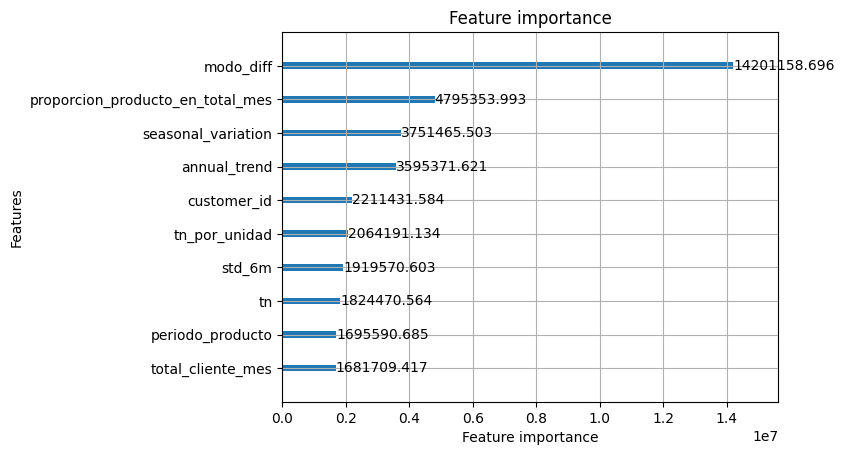

In [23]:
import matplotlib.pyplot as plt
from lightgbm import plot_importance  # Importación específica
# Visualizar importancia de características
plot_importance(model, importance_type='gain', max_num_features=10)  # Usar la función importada
plt.show()